In [1]:
# Libraries:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import Lasso

sys.path.append("/home/mattg/D_CODE") # Necessario al momento per far girare toolbox
from D_CODE.run_simulation import run as run_SRT
from D_CODE.run_simulation_vi import run as run_DCODE

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # include parent directory in the path
from toolbox.auxiliary_functions import set_param_freq
from data import equations
from data import SINDy_data

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


# Van der Pol ODE

Try the code on Van der Pol ODE System. In this case we expect SINDy to work well, being a combination of linear blocks up to the third order.

$$
\begin{cases}
\dot{x}_0 = \dfrac{1}{\mu}\left(x_1 - \tfrac{1}{3}x_0^3 + x_0\right), \\[8pt]
\dot{x}_1 = -x_0.
\end{cases}
$$

Consider the default parameter $\mu = 1$.

In [2]:
# Select ODE & settings:
ode_name = 'VdpODE' # help="name of the ode", type=str
ode_param = None # help="parameters of the ode (default: None)", type=str, default=None
freq = 25 # help="sampling frequency", type=float, default=10
dt = 1 / freq
n_sample = 20 # help="number of trajectories", type=int, default=100
noise_ratio = 0.10 # help="noise level (default 0)", type=float, default=0.
dim_x = 2 # help="dimentionality of the problem", type=int
dim_k = 0 # help="dimentionality of the parameterizaiton discovery", type=int
ode_param, freq = set_param_freq(ode_param, freq)
ode = equations.get_ode(ode_name, ode_param)
time_vector = np.arange(0, ode.T + dt, dt)

In [3]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name=ode_name, 
                                                                   ode_param=ode_param,
                                                                   freq=freq,
                                                                   n_sample=n_sample,
                                                                   noise_ratio=noise_ratio,
                                                                   dim_x=dim_x,
                                                                   dim_k=dim_k)

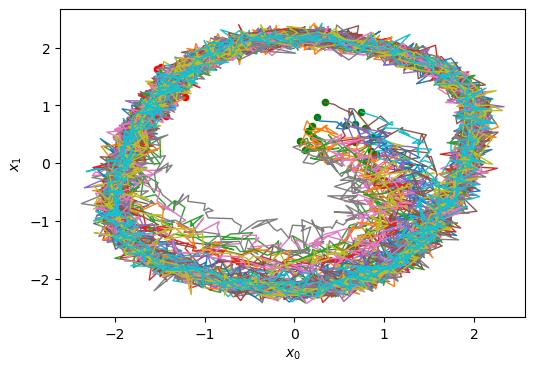

In [ ]:
# plot trajectory in state space
SINDy_data.plot_configuration(X_list)

Threshold:  0.01 , RMSE:  0.7294000675962785
Threshold:  0.05 , RMSE:  0.04748396439217285
Threshold:  0.1 , RMSE:  0.04748396439217285
Threshold:  0.2 , RMSE:  0.9079909770590417
Threshold:  0.4 , RMSE:  0.9079909770590417
Threshold:  0.6 , RMSE:  0.9079909770590417
Threshold:  0.8 , RMSE:  0.9079909770590417


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1.0) and eliminated all coefficients
  warnings.warn(


Threshold:  1.0 , RMSE:  1.5403733184781285


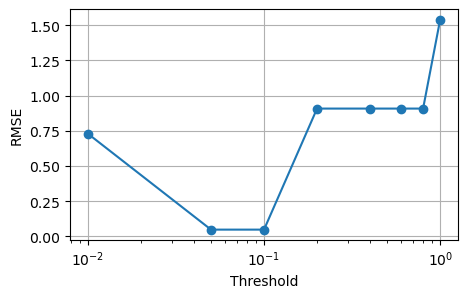

In [5]:
# model selection:
thresholds = np.array([0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.])
rmse_values = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=ps.STLSQ(threshold=thresholds[i]))
    model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
    rmse, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, [1., 1.], [0., 0.], dim_k)
    rmse_values[i] = rmse
    print('Threshold: ', thresholds[i], ', RMSE: ', rmse)  

plt.figure(figsize=(5, 3))
plt.plot(thresholds, rmse_values, marker='o')
plt.xlabel('Threshold')
plt.ylabel('RMSE')
plt.xscale('log')
plt.grid(True)
plt.show()

Best STLSQ coefficient: 0.1

In [6]:
model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=ps.STLSQ(threshold=0.1))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
print("Estimated SINDy model: ")
model.print()

Estimated SINDy model: 
(X0)' = 0.854 X0 + 0.978 X1 + -0.278 X0^3
(X1)' = -0.995 X0


Even with a high percentage of noise, SINDy is robust enougth to get the real model

In [7]:
# evaluation
rmse, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, [1., 1.], [0., 0.], dim_k)
print('Best Model RMSE: ', rmse)

Best Model RMSE:  0.04748396439217285


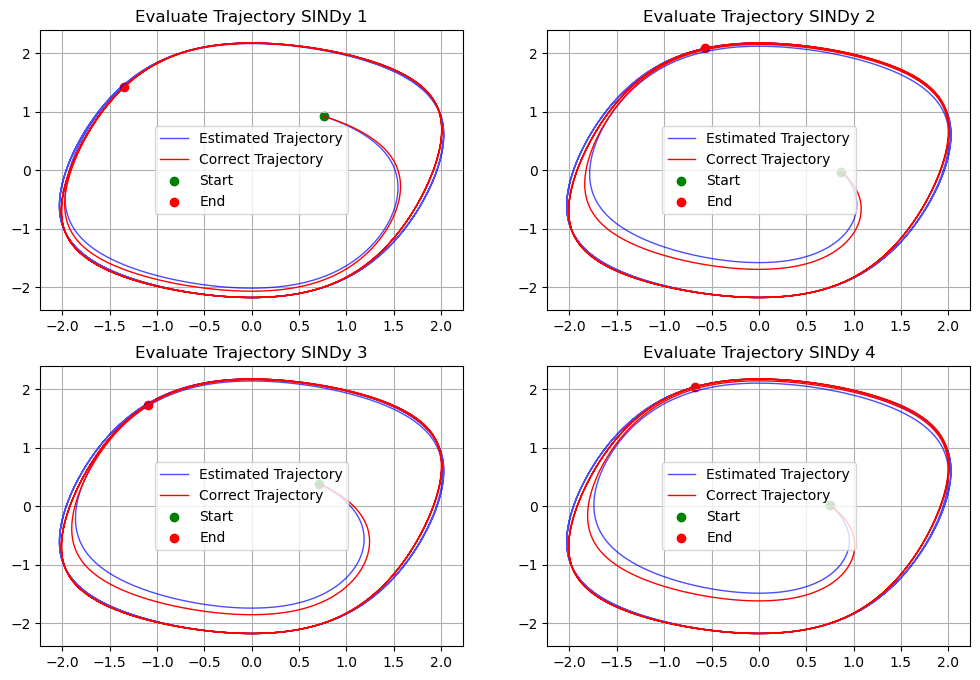

In [8]:
evaluate_sample = 4
title = 'Evaluate Trajectory SINDy'
SINDy_data.evaluate_traj(model, ode, freq, evaluate_sample, [1., 1.], [0., 0.], dim_x, dim_k, title=title)

In this kind of problem, SINDy shows its strength, being able to identify the true closed form ODE from data, and obtain really good reconstructions, even in situation with high noise.
The reconstructions is not perfect because of small errors in the coefficients estimation, however the true underlying model is recovered.

# Gompertz ODE

Consider the Gompertz Model:
$$ \dot{x}(t) = - a x(t) \log\!\bigl(b x(t)\bigr), \qquad a,b \in \mathbb{R}^{+} $$

In this case we are testing the generation code changing the ODE parameters (i.e. sampling the parameters $a$ and $b$ instead of considering them fixed) and the inaccuracy of SINDy for a nonlinear model without the required building blocks in the candidate functions library.

### Gompertz ODE - $a,b$ fixed

In [2]:
# Select ODE & settings:
ode_name = 'GompertzODE' # help="name of the ode", type=str
ode_param = '1.5,1.5' # help="parameters of the ode (default: None)", type=str, default=None
freq = 10 # help="sampling frequency", type=float, default=10
dt = 1 / freq
n_sample = 20 # help="number of trajectories", type=int, default=100
noise_ratio = 0.10 # help="noise level (default 0)", type=float, default=0.
dim_x = 1 # help="dimentionality of the problem", type=int
dim_k = 0 # help="dimentionality of the parameterizaiton discovery", type=int
ode_param, freq = set_param_freq(ode_param, freq)
ode = equations.get_ode(ode_name, ode_param)
time_vector = np.arange(0, ode.T + dt, dt)

In [3]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name=ode_name, 
                                                                   ode_param=ode_param,
                                                                   freq=freq,
                                                                   n_sample=n_sample,
                                                                   noise_ratio=noise_ratio,
                                                                   dim_x=dim_x,
                                                                   dim_k=dim_k
                                                                   )

# ensure existance conditions:
X_list = SINDy_data.existence_conditions(X_list, ode.init_low, n_variables=dim_x)

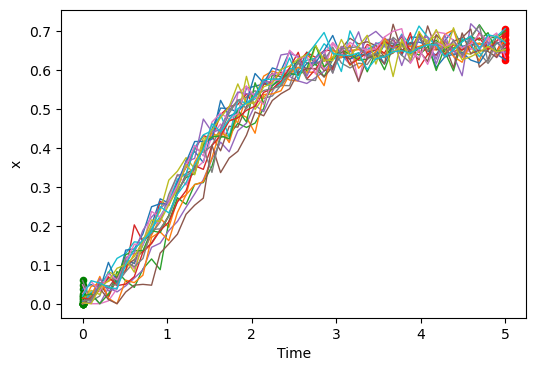

In [4]:
# plot trajectories in state space
SINDy_data.plot_configuration(X_list, ode.T)

Threshold:  0.01 , RMSE:  0.0223509994738685
Threshold:  0.05 , RMSE:  0.0223509994738685
Threshold:  0.1 , RMSE:  0.0223509994738685
Threshold:  0.2 , RMSE:  0.08359888757660514
Threshold:  0.4 , RMSE:  0.08359888757660514
Threshold:  0.6 , RMSE:  0.17933915549808185
Threshold:  0.8 , RMSE:  0.17933915549808185
Threshold:  1.0 , RMSE:  0.5148951030235676


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1.0) and eliminated all coefficients
  warnings.warn(


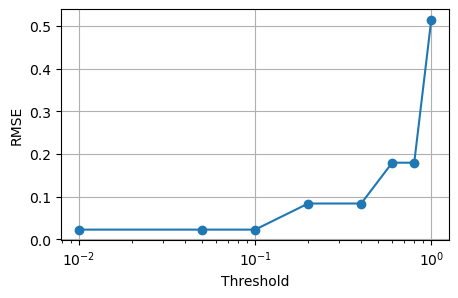

In [5]:
# model selection:
thresholds = np.array([0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.])
rmse_values = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=ps.STLSQ(threshold=thresholds[i]))
    model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
    rmse, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, [0.01], [0.], dim_k)
    rmse_values[i] = rmse
    print('Threshold: ', thresholds[i], ', RMSE: ', rmse)  

plt.figure(figsize=(5, 3))
plt.plot(thresholds, rmse_values, marker='o')
plt.xlabel('Threshold')
plt.ylabel('RMSE')
plt.xscale('log')
plt.grid(True)
plt.show()

In [6]:
model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=ps.STLSQ(threshold=0.1))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
print("Estimated SINDy model: ")
model.print()

Estimated SINDy model: 
(X0)' = 0.142 1 + 1.545 X0 + -3.528 X0^2 + 1.377 X0^3


Best Model RMSE:  0.0223509994738685


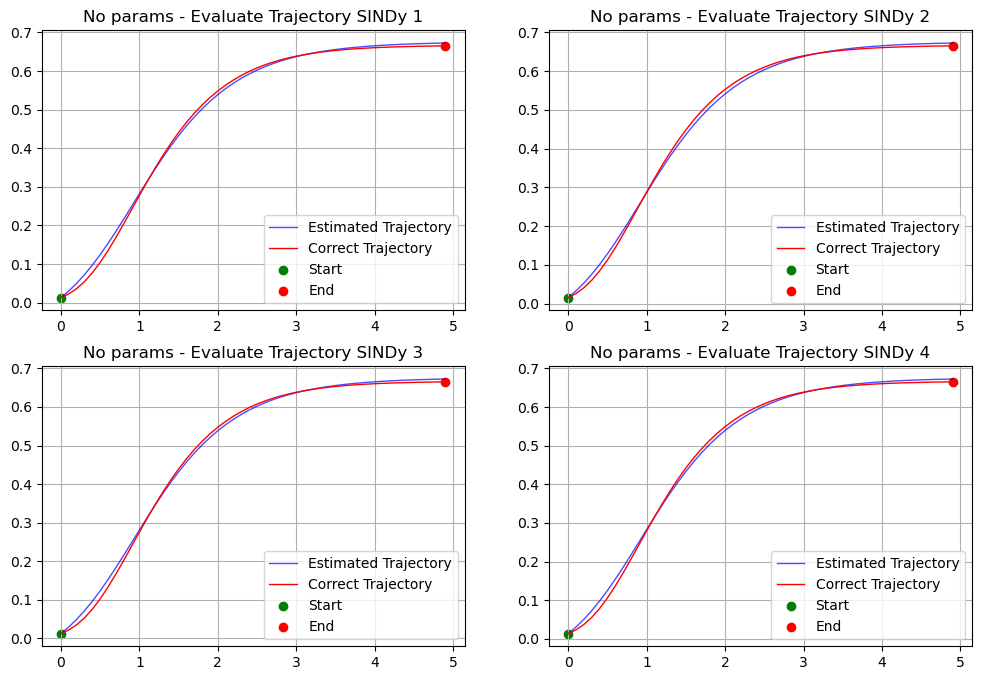

In [8]:
# evaluation
rmse, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, [0.01], [0.], dim_k)
print('Best Model RMSE: ', rmse)

evaluate_sample = 4
title = 'No params - Evaluate Trajectory SINDy'
SINDy_data.evaluate_traj(model, ode, freq, evaluate_sample, [0.01], [0.], dim_x, dim_k, title=title, T_aux=5)

With fixed parameters, even though SINDy is not able to discover the real underlying dynamics, we have a really small RMSE, obtaining a good approximation. Hence, given the initial condition it is able to approximate well the evolution.

What if we include the real term in the library? -> add $\log(1.5x)$

Threshold:  0.01 , RMSE:  0.020656640664947302
Threshold:  0.05 , RMSE:  0.01225645607759249
Threshold:  0.1 , RMSE:  0.014565048935579899
Threshold:  0.2 , RMSE:  0.02000519907268159
Threshold:  0.3 , RMSE:  0.017576854086744635


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.4) and eliminated all coefficients
  warnings.warn(


Threshold:  0.4 , RMSE:  0.5148951030235676


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.6) and eliminated all coefficients
  warnings.warn(


Threshold:  0.6 , RMSE:  0.5148951030235676


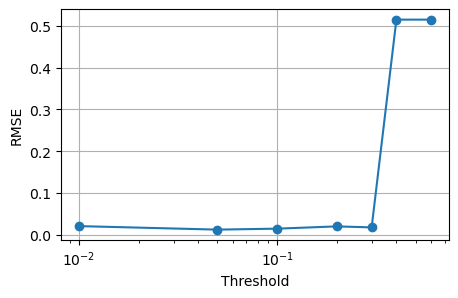

In [14]:
# define the polynomial library
poly_lib = ps.PolynomialLibrary(degree=3)

# define new building blocks in a custon library
library_functions = [lambda x: np.log(x),
                     lambda x: np.log(1.5*x),
                     lambda x: np.log(2*x)]

library_function_names = [lambda x: 'log(' + x + ')',
                          lambda x: 'log(1.5 * ' + x + ')',
                          lambda x: 'log(2 * ' + x + ')']

custom_lib = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names
)

# combine PolynomialLibrary and CustomLibrary (log)
combined_lib = ps.GeneralizedLibrary([poly_lib, custom_lib], tensor_array=[[1,1]])

# model selection:
thresholds = np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6])
rmse_values = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    model_new = ps.SINDy(feature_names=feature_names, feature_library=combined_lib, optimizer=ps.STLSQ(threshold=thresholds[i]))
    model_new.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
    rmse, _ = SINDy_data.evaluate_RMSE(model_new, ode, freq, n_sample, [0.01], [0.], dim_k)
    rmse_values[i] = rmse
    print('Threshold: ', thresholds[i], ', RMSE: ', rmse)  

plt.figure(figsize=(5, 3))
plt.plot(thresholds, rmse_values, marker='o')
plt.xlabel('Threshold')
plt.ylabel('RMSE')
plt.xscale('log')
plt.grid(True)
plt.show()

In this case there are different STSLQ coefficient with close error: -> chose the one which promote an higher sparsity! 

In [11]:
model = ps.SINDy(feature_names=feature_names, feature_library=combined_lib, optimizer=ps.STLSQ(threshold=0.3))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
print("Estimated SINDy model: ")
model.print()

Estimated SINDy model: 
(X0)' = -1.397 X0 log(1.5 * X0)


Best Model RMSE:  0.017576854086744635


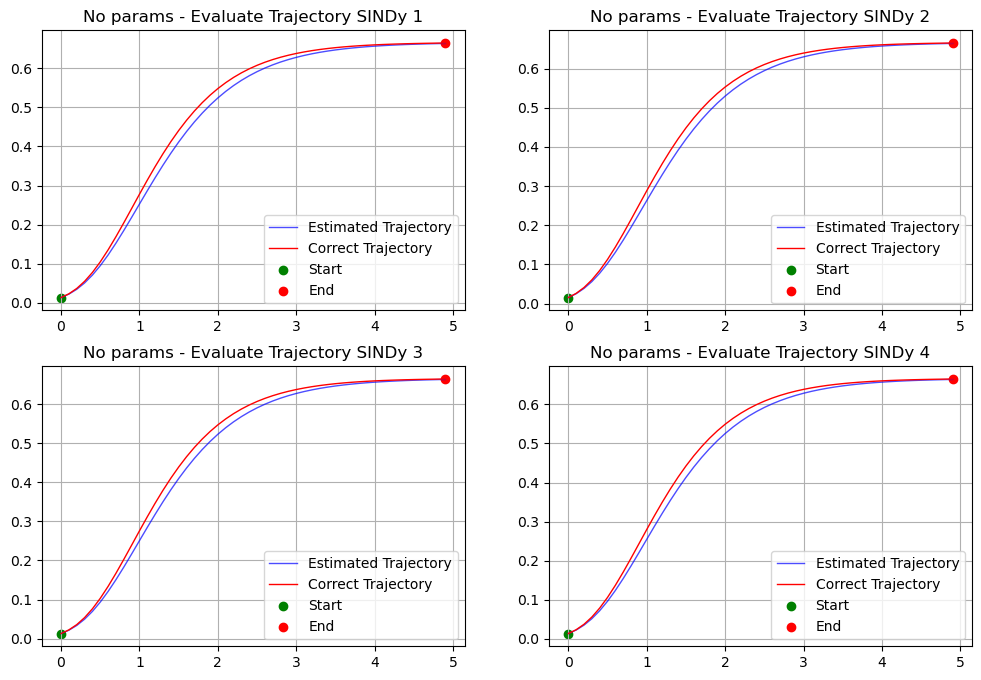

In [13]:
# evaluation
rmse, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, [0.01], [0.], dim_k)
print('Best Model RMSE: ', rmse)

# Test
evaluate_sample = 4
title = 'No params - Evaluate Trajectory SINDy'
SINDy_data.evaluate_traj(model, ode, freq, evaluate_sample, [0.01], [0.], dim_x, dim_k, title=title, T_aux = 5)

SINDy, if provided of the right building block does the job quite well, even in situaiton with high noise!

### Gompertz ODE - $a,b$ varying

In [15]:
# Select ODE & settings:
ode_name = 'GompertzODE_par_ab' # help="name of the ode", type=str
ode_param = None # help="parameters of the ode (default: None)", type=str, default=None
freq = 10 # help="sampling frequency", type=float, default=10
dt = 1 / freq
n_sample = 20 # help="number of trajectories", type=int, default=100
noise_ratio = 0.10 # help="noise level (default 0)", type=float, default=0.
dim_x = 1 # help="dimentionality of the problem", type=int
dim_k = 2 # help="dimentionality of the parameterizaiton discovery", type=int
ode_param, freq = set_param_freq(ode_param, freq)
ode = equations.get_ode(ode_name, ode_param)
time_vector = np.arange(0, ode.T + dt, dt)

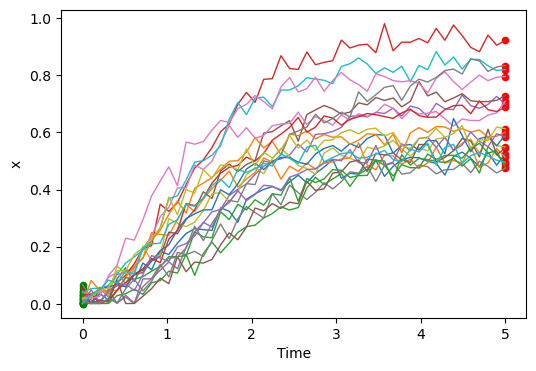

In [16]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name=ode_name, 
                                                                   ode_param=ode_param,
                                                                   freq=freq,
                                                                   n_sample=n_sample,
                                                                   noise_ratio=noise_ratio,
                                                                   dim_x=dim_x,
                                                                   dim_k=dim_k)

# ensure existance conditions:
X_list = SINDy_data.existence_conditions(X_list, ode.init_low, n_variables=dim_x)

# plot the trajectory:
SINDy_data.plot_configuration(X_list, ode.T)

NOTE: the parameterization with respect to $a$ and $b$ is done adding two new constant equation in  equations.py. In each simulation the parameters are sampled in a specified range, and are kept constant thoughout the trajectory. Practically speaking, those elements (saved in param_list) are passed to SINDy as external control variables of the model.

Threshold:  0.01 , RMSE:  0.02641062676187549
Threshold:  0.05 , RMSE:  0.026798118547384658
Threshold:  0.1 , RMSE:  0.10949402036607106
Threshold:  0.2 , RMSE:  0.11062950704820787
Threshold:  0.4 , RMSE:  0.19667219902026453
Threshold:  0.6 , RMSE:  0.20909775594172975


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.8) and eliminated all coefficients
  warnings.warn(


Threshold:  0.8 , RMSE:  0.5275213779518553


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1.0) and eliminated all coefficients
  warnings.warn(


Threshold:  1.0 , RMSE:  0.5275213779518553


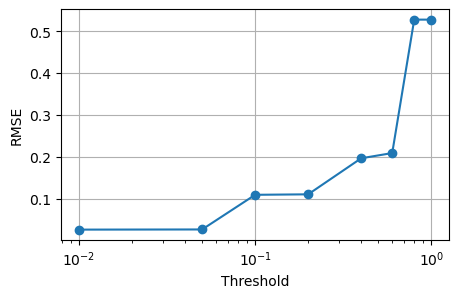

In [17]:
# model selection:
thresholds = np.array([0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.])
rmse_values = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    model_ab = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3), optimizer=ps.STLSQ(threshold=thresholds[i]))
    model_ab.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
    rmse, _ = SINDy_data.evaluate_RMSE(model_ab, ode, freq, n_sample, [0.01, 2., 2.], [0., 1., 1.], dim_k)
    rmse_values[i] = rmse
    print('Threshold: ', thresholds[i], ', RMSE: ', rmse)  

plt.figure(figsize=(5, 3))
plt.plot(thresholds, rmse_values, marker='o')
plt.xlabel('Threshold')
plt.ylabel('RMSE')
plt.xscale('log')
plt.grid(True)
plt.show()

In [18]:
model_ab = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3), optimizer=ps.STLSQ(threshold=0.05))
model_ab.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
print("Estimated SINDy model: ")
model_ab.print()

Estimated SINDy model: 
(X0)' = 0.040 1 + 2.716 X0 + 0.043 X1 + -0.110 X2 + -4.181 X0^2 + 1.246 X0 X1 + -1.211 X0 X2 + 1.690 X0^3 + -0.410 X0^2 X1 + 0.598 X0^2 X2 + -0.339 X0 X1^2 + -0.214 X0 X1 X2 + 0.093 X0 X2^2 + 0.081 X1^3 + -0.125 X1^2 X2 + 0.091 X1 X2^2


Best Model RMSE:  0.026798118547384658


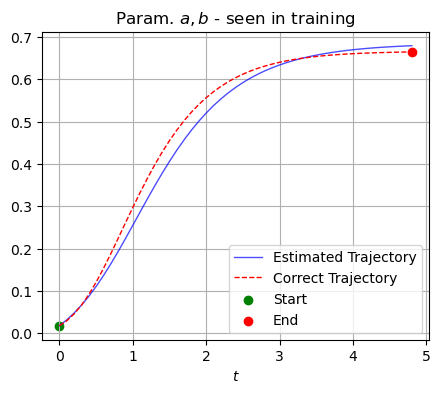

In [20]:
# evaluation
rmse, _ = SINDy_data.evaluate_RMSE(model_ab, ode, freq, n_sample, [0.01, 2., 2.], [0., 1., 1.], dim_k)
print('Best Model RMSE: ', rmse)

# test
n_sample = 1
title = 'Param. $a, b$ - seen in training'
SINDy_data.evaluate_traj(model_ab, ode, freq, n_sample, [0.01, 1.5, 1.5], [0.01, 1.5, 1.5], dim_x, dim_k, title=title)

Best Model RMSE:  0.08538807945208442
Best Model RMSE:  0.02002821544095528


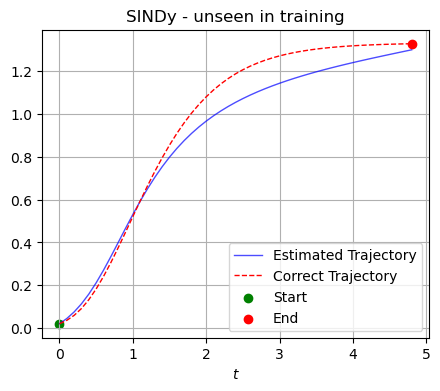

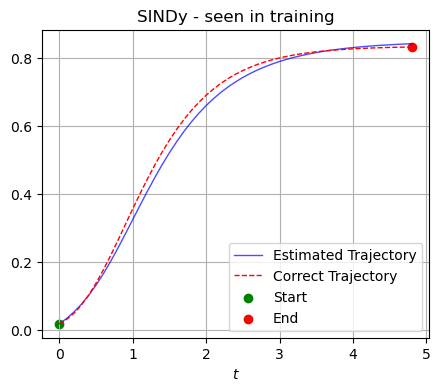

In [21]:
# overfitting issues:
init_point = [0.01, 1.5, 0.75]
n_sample = 3
rmse_ab, _ = SINDy_data.evaluate_RMSE(model_ab, ode, freq, n_sample, init_point, init_point, dim_k)
print('Best Model RMSE: ', rmse_ab)

n_sample = 1
title = 'SINDy - unseen in training'
SINDy_data.evaluate_traj(model_ab, ode, freq, n_sample, init_point, init_point, dim_x, dim_k, title=title)

# same initial condizion, in training:
init_point = [0.01, 1.5, 1.2]
n_sample = 3
rmse_ab, _ = SINDy_data.evaluate_RMSE(model_ab, ode, freq, n_sample, init_point, init_point, dim_k)
print('Best Model RMSE: ', rmse_ab)

n_sample = 1
title = 'SINDy - seen in training'
SINDy_data.evaluate_traj(model_ab, ode, freq, n_sample, init_point, init_point, dim_x, dim_k, title=title)

Not having the right building blocks inside the CFL, the best SINDy could do is approximate the dynimacs with linear combination of blocks, including the parameterization on $a$ and $b$. The underlying model is NOT recovered, indeed, even if the RMSE is small and the approximation is quite good within the training domain, we can notice a wierd behaviour outside the training domain, indicating a lack of generalization.